## Harsh Sharma

### Neural networks

---

### Motive for this file:
As we have trained various kind of models previously on our dataset, mainly random forest classifier and XGBoost Classifier, here we are going to do a more advanced and more complex model and check and compare the accuracies & performance with the previous models. 


So let's dig deeper into neural networks. Running a basic neural network amd then keep on adding some modifications to it and also do some changes to the data to achieve a desirable result.

---

Following three blocks of code are for activating GPU RAM in google colab.

In [1]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [2]:
!cat /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h |\
grep TF_CUDA_VERSION

cat: /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h: No such file or directory


In [3]:
# Importing everything we need 
# The usual packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# Splitting data
from sklearn.model_selection import train_test_split 

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer

import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, BatchNormalization
from keras.optimizers import Adam

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

Let's mount the google drive for importing files and data

In [5]:
import os
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [6]:
path = '/content/drive/MyDrive/news data/'
main_df = pd.read_csv(path+'file_name.csv')

In [7]:
# peeking into the dataset
main_df.head()

,Unnamed: 0,category,headline
0,0,WORLD NEWS,Over Million Americans Roll Up Sleeves For Om...
1,1,WORLD NEWS,American Airlines Flyer Charged Banned For Li...
2,2,COMEDY,Of The Funniest Tweets About Cats And Dogs Th...
3,3,PARENTING,The Funniest Tweets From Parents This Week Se...
4,4,WORLD NEWS,Woman Who Called Cops On Black Bird Watcher Lo...


While converting the dataframe to csv index has to be false, otherwise it adds one extra column as seen from above

In [8]:
# checking shape
main_df.shape

(209323, 3)

In [9]:
# checking the missing values
main_df.isna().sum() 

Unnamed: 0     0
category       0
headline      29
dtype: int64

Some of the cells in the headline columns were empty strings, which are dropped below. These are just 29 compared to 250k in our dataset

In [10]:
# dropping nan values
main_df.dropna(inplace=True)

In [11]:
# sanity check
main_df.isna().sum()

Unnamed: 0    0
category      0
headline      0
dtype: int64

In [12]:
def PlotBoundaries(model, X, Y, figsize=(8, 6)):
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
    plt.show()

In [13]:
def PlotEnsembleBoundaries(ensembles, X, Y, shape, figsize=(10, 7)):
    '''
    Helper function to plot the boundaries of ensemble methods.
    code modified from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html
    '''
    fig, axes = plt.subplots(shape[0], shape[1], figsize=figsize)
    for i, (ax, model) in enumerate(zip(axes.ravel(), ensembles)):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.4)

        # Plot
        ax.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Let's do some preprocessing before fitting the models

In [14]:
# making every word of small letters
main_df['headline'] = main_df['headline'].str.lower()

In [15]:
# defining independent and dependent variables
X = main_df[['headline']]
y = main_df['category']

In [16]:
from sklearn.preprocessing import LabelEncoder

# applying label encoding to the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)

As our 'category' column has 23 classes let's change these numbers before we start our modelling so that we don't have any categorical columns present in the dataset.

Let's split the data into train and test sets...

In [17]:
# splitting into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [18]:
# random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

In [19]:
# the python string package has a helpful punctuation list
import string
print(string.punctuation)

import nltk
stemmer = nltk.stem.PorterStemmer()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Let's create and initiate our custom tokeniser and fit it into our train set and then transforming train and test set both.

In [20]:

# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's fit the above function to the dataset 

In [21]:
# let's do it for our dataset
bagofwords = TfidfVectorizer(min_df=3, max_df=0.2, max_features=3000, strip_accents='unicode', analyzer='word', ngram_range=(1, 10),
                             stop_words='english', 
                             tokenizer=my_tokenizer)
bagofwords.fit(X_train['headline'])

train_vec = bagofwords.transform(X_train['headline'])
test_vec = bagofwords.transform(X_test['headline'])

train_vec.shape

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaf

(167435, 3000)

All set let's start the modelling

### Basic neural network model

In [ ]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
#model.add(tf.keras.layers.InputLayer(input_shape=(1,)))

model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

let's sort the indices before fitting the above model.

In [ ]:
train_vec.sort_indices()
test_vec.sort_indices()

In [ ]:
# Fit the model
history = model.fit(train_vec, y_train, epochs=25, verbose=5)

Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25


In [ ]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(test_vec, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

predictions = model.predict(test_vec)


Train Accuracy: 0.9430
Test Accuracy: 0.5324
1309/1309 [==============================] - 3s 2ms/step


Wow, this is the highest accuracy ever achieved on the training data, but sadly we have a lot lot of overfitting.

We can fix the overfitting of the model using dropout layers for after each layer we have for the neural networks AND L2 regularisation can also be done to put more weights on the features which are less important.

Let's do it

### Neural network with regualrization on the hidden layers

In [ ]:
# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.00005)

# Declare the hidden layers
model.add(layers.Dense(1024, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
# check
train_vec.shape, y_train.shape

((167435, 3000), (167435,))

In [ ]:
# Fit the model
history = model.fit(train_vec, y_train, epochs=25, verbose=1)

Epoch 1/25


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/dense_20/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/dense_20/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/dense_20/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


5233/5233 [==============================] - 23s 4ms/step - loss: 1.9172 - sparse_categorical_accuracy: 0.5231
Epoch 2/25
5233/5233 [==============================] - 23s 4ms/step - loss: 1.7053 - sparse_categorical_accuracy: 0.5833
Epoch 3/25
5233/5233 [==============================] - 23s 4ms/step - loss: 1.6127 - sparse_categorical_accuracy: 0.6064
Epoch 4/25
5233/5233 [==============================] - 23s 4ms/step - loss: 1.5361 - sparse_categorical_accuracy: 0.6300
Epoch 5/25
5233/5233 [==============================] - 23s 4ms/step - loss: 1.4571 - sparse_categorical_accuracy: 0.6592
Epoch 6/25
5233/5233 [==============================] - 23s 4ms/step - loss: 1.3678 - sparse_categorical_accuracy: 0.6937
Epoch 7/25
5233/5233 [==============================] - 23s 4ms/step - loss: 1.2777 - sparse_categorical_accuracy: 0.7285
Epoch 8/25
5233/5233 [==============================] - 23s 4ms/step - loss: 1.2071 - sparse_categorical_accuracy: 0.7557
Epoch 9/25
5233/5233 [=============

In [ ]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(test_vec, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8391
Test Accuracy: 0.5181


That's poor performance

### Adding droput layers along with regularization

In [ ]:
# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.00005)

# Declare the hidden layers
model.add(layers.Dense(1024, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.6))  
model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4)) 
model.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4)) 
model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.2)) 

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
# Fit the model
history = model.fit(train_vec, y_train, epochs=25, verbose=1)

Epoch 1/25


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_5/dense_25/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_5/dense_25/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_5/dense_25/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


5233/5233 [==============================] - 25s 4ms/step - loss: 2.2296 - sparse_categorical_accuracy: 0.4606
Epoch 2/25
5233/5233 [==============================] - 25s 5ms/step - loss: 2.1110 - sparse_categorical_accuracy: 0.5390
Epoch 3/25
5233/5233 [==============================] - 24s 4ms/step - loss: 2.0926 - sparse_categorical_accuracy: 0.5533
Epoch 4/25
5233/5233 [==============================] - 24s 5ms/step - loss: 2.0760 - sparse_categorical_accuracy: 0.5636
Epoch 5/25
5233/5233 [==============================] - 24s 4ms/step - loss: 2.0674 - sparse_categorical_accuracy: 0.5685
Epoch 6/25
5233/5233 [==============================] - 24s 4ms/step - loss: 2.0523 - sparse_categorical_accuracy: 0.5733
Epoch 7/25
5233/5233 [==============================] - 24s 4ms/step - loss: 2.0400 - sparse_categorical_accuracy: 0.5776
Epoch 8/25
5233/5233 [==============================] - 24s 5ms/step - loss: 2.0311 - sparse_categorical_accuracy: 0.5792
Epoch 9/25
5233/5233 [=============

In [ ]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(test_vec, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.5879
Test Accuracy: 0.5847


Ok so it fitted the overfitting of the model but had overall accuracy decreased

### Doing batch normalisation on the hidden layers of the neural network

In [ ]:
# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.00005)

# Declare the hidden layers
model.add(layers.Dense(1024, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer)) 
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
# Fit the model
history = model.fit(train_vec, y_train, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_9/dense_45/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_9/dense_45/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_9/dense_45/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


5233/5233 [==============================] - 34s 6ms/step - loss: 2.0548 - sparse_categorical_accuracy: 0.4982
Epoch 2/10
5233/5233 [==============================] - 33s 6ms/step - loss: 1.9757 - sparse_categorical_accuracy: 0.5576
Epoch 3/10
5233/5233 [==============================] - 32s 6ms/step - loss: 1.9710 - sparse_categorical_accuracy: 0.5720
Epoch 4/10
5233/5233 [==============================] - 33s 6ms/step - loss: 1.9321 - sparse_categorical_accuracy: 0.5874
Epoch 5/10
5233/5233 [==============================] - 33s 6ms/step - loss: 1.8825 - sparse_categorical_accuracy: 0.6003
Epoch 6/10
5233/5233 [==============================] - 33s 6ms/step - loss: 1.8385 - sparse_categorical_accuracy: 0.6142
Epoch 7/10
5233/5233 [==============================] - 32s 6ms/step - loss: 1.8067 - sparse_categorical_accuracy: 0.6257
Epoch 8/10
5233/5233 [==============================] - 33s 6ms/step - loss: 1.7743 - sparse_categorical_accuracy: 0.6355
Epoch 9/10
5233/5233 [=============

In [ ]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(test_vec, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.6520
Test Accuracy: 0.5764


### Dimensionality reduction and checking the performance

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scaler.fit(train_vec)

StandardScaler(with_mean=False)

In [23]:
# Fit the scaler and transform both data subsets
X_train = scaler.transform(train_vec)
X_test = scaler.transform(test_vec)

In [24]:
from sklearn.decomposition import TruncatedSVD

PCA only works on the arrays or dataframes for dimensionality reduction. __TruncatedSVD__ is used for the feature reduction in case of sparse matrices as in our case.

In [25]:
clf = TruncatedSVD(2999) # by default the number of estimators is 2
X_train_d = clf.fit_transform(train_vec)

In [26]:
# doing SVD on the test set
X_test_d = clf.transform(test_vec)

Now let's see what is the proportional variance explained by the features by using the following attribute.

In [27]:
# variance explained by the features
clf.explained_variance_ratio_

array([4.70968164e-03, 3.82728669e-03, 3.53816441e-03, ...,
       8.02426278e-34, 1.04642097e-33, 1.04963363e-33])

In [28]:
# check
X_train_d.shape, X_test_d.shape, train_vec.shape, test_vec.shape

((167435, 2999), (41859, 2999), (167435, 3000), (41859, 3000))

In [29]:
# Pull out the explained variance ratio
expl_var = clf.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

cumulative_sum

array([0.00470968, 0.00853697, 0.01207513, ..., 1.        , 1.        ,
       1.        ])

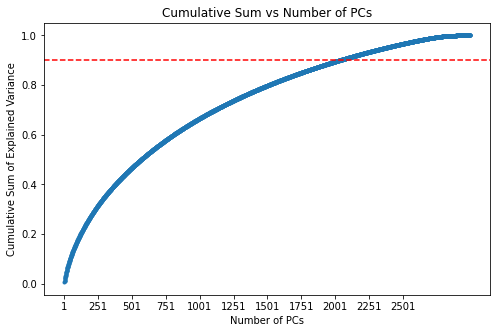

In [30]:
# Plot out the cumulative sum graph
plt.figure(figsize=(8,5))
plt.plot(range(1,3000), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--') #keeping 90% threshhold of the explained variance
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.title('Cumulative Sum vs Number of PCs')
plt.xticks(range(1,2744,250))
plt.show()

In [31]:
# function for calling the maximum PCs at the 90% threshhold
np.argmax(cumulative_sum >= 0.90)

2035

So we are going to select 2035 features out of 3000 features and check the accuracy of the model.

In [32]:
# Instantiate and fit
clf2 = TruncatedSVD(n_components = np.argmax(cumulative_sum >= 0.90))
clf2.fit(train_vec)

# Transform train and test
X_train_TV = clf2.transform(train_vec)
X_test_TV = clf2.transform(test_vec)

In [33]:
# check
X_train_TV.shape, X_test_TV.shape, y_train.shape

((167435, 2035), (41859, 2035), (167435,))

In [34]:
X_train_TV

array([[ 0.0245056 ,  0.02350219, -0.01079472, ..., -0.00831995,
         0.00458984,  0.0190522 ],
       [ 0.01371547,  0.01488538, -0.01629741, ...,  0.00231904,
         0.0014877 , -0.00654063],
       [ 0.02058291,  0.03832184, -0.0073863 , ..., -0.01252788,
         0.00528721,  0.01358537],
       ...,
       [ 0.02417437,  0.03016344, -0.02889045, ..., -0.00232929,
        -0.0073996 , -0.00992508],
       [ 0.07339916,  0.19126977,  0.11394014, ...,  0.01573745,
        -0.00524853,  0.02475953],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# from scipy import sparse
# sA = sparse.csr_matrix(X_train_TV)   # Here's the initialization of the sparse matrix.
# #sB = sparse.csr_matrix(B)

Let's define our model amd then check the accuarcy

In [35]:
# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.00005)

# Declare the hidden layers
model.add(layers.Dense(1024, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer)) 
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [36]:
# Fit the model
history = model.fit(X_train_TV, y_train, epochs=25, verbose=1)

Epoch 1/25
5233/5233 [==============================] - 30s 5ms/step - loss: 2.0678 - sparse_categorical_accuracy: 0.4980
Epoch 2/25
5233/5233 [==============================] - 26s 5ms/step - loss: 1.9586 - sparse_categorical_accuracy: 0.5623
Epoch 3/25
5233/5233 [==============================] - 26s 5ms/step - loss: 1.9656 - sparse_categorical_accuracy: 0.5803
Epoch 4/25
5233/5233 [==============================] - 25s 5ms/step - loss: 1.9480 - sparse_categorical_accuracy: 0.5931
Epoch 5/25
5233/5233 [==============================] - 26s 5ms/step - loss: 1.9247 - sparse_categorical_accuracy: 0.6048
Epoch 6/25
5233/5233 [==============================] - 26s 5ms/step - loss: 1.9029 - sparse_categorical_accuracy: 0.6139
Epoch 7/25
5233/5233 [==============================] - 25s 5ms/step - loss: 1.8844 - sparse_categorical_accuracy: 0.6230
Epoch 8/25
5233/5233 [==============================] - 25s 5ms/step - loss: 1.8724 - sparse_categorical_accuracy: 0.6293
Epoch 9/25
5233/5233 [==

In [37]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test_TV, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.6654
Test Accuracy: 0.5777


Fixed some of the overfitting, but the accuracy is still low

We increased the accuracy to 57.77%, earlier it was 57.64%

### Adding short_description column

In [29]:
path = '/content/drive/MyDrive/news data/'
final_df = pd.read_csv(path+'finaldata.csv')

In [30]:
# peeking into the dataset
final_df.head()

,category,headline,description
0,WORLD NEWS,Over Million Americans Roll Up Sleeves For Om...,Health experts said it is too early to predict...
1,WORLD NEWS,American Airlines Flyer Charged Banned For Li...,He was subdued by passengers and crew when he ...
2,COMEDY,Of The Funniest Tweets About Cats And Dogs Th...,Until you have a dog you don t understand wha...
3,PARENTING,The Funniest Tweets From Parents This Week Se...,Accidentally put grown up toothpaste on my to...
4,WORLD NEWS,Woman Who Called Cops On Black Bird Watcher Lo...,Amy Cooper accused investment firm Franklin Te...


In [31]:
# checking shape
final_df.shape

(209323, 3)

Let's combine the text of the headline column and short description column and then check the performance of the model.

In [32]:
final_df['text'] = final_df['headline'] + " " + final_df['description']

In [33]:
# combining 2 columns
final_df.head()

,category,headline,description,text
0,WORLD NEWS,Over Million Americans Roll Up Sleeves For Om...,Health experts said it is too early to predict...,Over Million Americans Roll Up Sleeves For Om...
1,WORLD NEWS,American Airlines Flyer Charged Banned For Li...,He was subdued by passengers and crew when he ...,American Airlines Flyer Charged Banned For Li...
2,COMEDY,Of The Funniest Tweets About Cats And Dogs Th...,Until you have a dog you don t understand wha...,Of The Funniest Tweets About Cats And Dogs Th...
3,PARENTING,The Funniest Tweets From Parents This Week Se...,Accidentally put grown up toothpaste on my to...,The Funniest Tweets From Parents This Week Se...
4,WORLD NEWS,Woman Who Called Cops On Black Bird Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird Watcher Lo...


In [34]:
# dropping unwanted columns
final_df.drop(columns=['headline', 'description'], inplace=True)

In [35]:
# check
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209323 entries, 0 to 209322
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  209323 non-null  object
 1   text      209278 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [14]:
# checking null values
final_df.isna().sum()

category     0
text        45
dtype: int64

These can be empty strings present in the dataframe which when converted to csv file resulted in null values.


So let's drop them...

In [36]:
# dropping null values 
final_df.dropna(inplace=True)

In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209278 entries, 0 to 209322
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  209278 non-null  object
 1   text      209278 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


As we can see from the dataset that words in the text column do not have all letters lower cased. Let's make each word in lowercase format so that no word is counted multiple times.

In [38]:
# making every word of small letters
final_df['text'] = final_df['text'].str.lower()

In [39]:
# defining independent and dependent variables
X = final_df[['text']]
y = final_df['category']

Since our dependent variable has 23 classes, let's change that to numerics using one-hot encoding.

In [41]:
from sklearn.preprocessing import LabelEncoder
# applying label encoding to the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [42]:
# splitting into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [43]:
# let's do it for our dataset
bagofwords = TfidfVectorizer(min_df=3, max_df=0.2, max_features=4000, strip_accents='unicode', analyzer='word', ngram_range=(1, 10),
                             stop_words='english', 
                             tokenizer=my_tokenizer)
bagofwords.fit(X_train['text'])

train_vec2 = bagofwords.transform(X_train['text'])
test_vec2 = bagofwords.transform(X_test['text'])

train_vec2.shape

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaf

(167422, 4000)

In [27]:
# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.00005)

# Declare the hidden layers
model.add(layers.Dense(1024, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer)) 
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [29]:
train_vec2.sort_indices()
test_vec2.sort_indices()

In [30]:
# Fit the model
history = model.fit(train_vec2, y_train, epochs=25, verbose=1)

Epoch 1/25


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


5232/5232 [==============================] - 40s 7ms/step - loss: 1.8595 - sparse_categorical_accuracy: 0.5533
Epoch 2/25
5232/5232 [==============================] - 37s 7ms/step - loss: 1.8032 - sparse_categorical_accuracy: 0.6189
Epoch 3/25
5232/5232 [==============================] - 36s 7ms/step - loss: 1.8087 - sparse_categorical_accuracy: 0.6403
Epoch 4/25
5232/5232 [==============================] - 36s 7ms/step - loss: 1.7636 - sparse_categorical_accuracy: 0.6638
Epoch 5/25
5232/5232 [==============================] - 36s 7ms/step - loss: 1.7148 - sparse_categorical_accuracy: 0.6848
Epoch 6/25
5232/5232 [==============================] - 37s 7ms/step - loss: 1.6588 - sparse_categorical_accuracy: 0.7080
Epoch 7/25
5232/5232 [==============================] - 36s 7ms/step - loss: 1.6168 - sparse_categorical_accuracy: 0.7223
Epoch 8/25
5232/5232 [==============================] - 36s 7ms/step - loss: 1.5752 - sparse_categorical_accuracy: 0.7384
Epoch 9/25
5232/5232 [=============

In [32]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(test_vec2, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.7879
Test Accuracy: 0.6005


Overall accuarcy improved here but overfitting can be seen here. So let's manage it.

Try making a new model, with less layers and nodes.

In [33]:
# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.00005)

# Declare the hidden layers
model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4)) 
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [36]:
# Fit the model
history = model.fit(train_vec2, y_train, epochs=10, batch_size = 100, verbose=1)

Epoch 1/10
1675/1675 [==============================] - 11s 6ms/step - loss: 1.7481 - sparse_categorical_accuracy: 0.5783
Epoch 2/10
1675/1675 [==============================] - 11s 6ms/step - loss: 1.6612 - sparse_categorical_accuracy: 0.6119
Epoch 3/10
1675/1675 [==============================] - 11s 6ms/step - loss: 1.6154 - sparse_categorical_accuracy: 0.6434
Epoch 4/10
1675/1675 [==============================] - 11s 6ms/step - loss: 1.5563 - sparse_categorical_accuracy: 0.6761
Epoch 5/10
1675/1675 [==============================] - 11s 6ms/step - loss: 1.4966 - sparse_categorical_accuracy: 0.7076
Epoch 6/10
1675/1675 [==============================] - 11s 6ms/step - loss: 1.4428 - sparse_categorical_accuracy: 0.7338
Epoch 7/10
1675/1675 [==============================] - 12s 7ms/step - loss: 1.4007 - sparse_categorical_accuracy: 0.7547
Epoch 8/10
1675/1675 [==============================] - 11s 6ms/step - loss: 1.3658 - sparse_categorical_accuracy: 0.7727
Epoch 9/10
1675/1675 [==

In [37]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(test_vec2, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.7980
Test Accuracy: 0.6065


Didn't affect much of the overfitting.

Let's try one more model.

In [97]:
# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.0005)

# Declare the hidden layers
model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.2))
#model.add(layers.BatchNormalization())

model.add(layers.Dense(256, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

# model.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizer))
# model.add(layers.Dropout(0.4))
# model.add(layers.BatchNormalization())


model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
#model.add(layers.Dropout(0.2)) 
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(23, activation="softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [98]:
train_vec2.sort_indices()
test_vec2.sort_indices()

To find the optimal value of epochs let's split the train_vec2 into 2 various sets to prevent data leakage.

In [99]:
# splitting into train and test splits
X_remainder, X_validation, y_remainder, y_validation = train_test_split(train_vec2, y_train, test_size=0.20, random_state=1, stratify=y_train)

In [100]:
# Fit the model
history = model.fit(train_vec2, y_train, epochs=25, batch_size = 100, verbose=1, validation_data=(X_validation, y_validation))

Epoch 1/25


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_7/dense_35/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_7/dense_35/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_7/dense_35/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1675/1675 [==============================] - 14s 7ms/step - loss: 2.2864 - sparse_categorical_accuracy: 0.5560 - val_loss: 1.7126 - val_sparse_categorical_accuracy: 0.6715
Epoch 2/25
1675/1675 [==============================] - 11s 6ms/step - loss: 1.8896 - sparse_categorical_accuracy: 0.6206 - val_loss: 1.6401 - val_sparse_categorical_accuracy: 0.6834
Epoch 3/25
1675/1675 [==============================] - 12s 7ms/step - loss: 1.8784 - sparse_categorical_accuracy: 0.6299 - val_loss: 1.6137 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/25
1675/1675 [==============================] - 11s 6ms/step - loss: 1.8738 - sparse_categorical_accuracy: 0.6387 - val_loss: 1.5988 - val_sparse_categorical_accuracy: 0.7087
Epoch 5/25
1675/1675 [==============================] - 11s 6ms/step - loss: 1.8558 - sparse_categorical_accuracy: 0.6470 - val_loss: 1.5488 - val_sparse_categorical_accuracy: 0.7276
Epoch 6/25
1675/1675 [==============================] - 11s 6ms/step - loss: 1.8272 - sparse_cat

In [101]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(test_vec2, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")


Train Accuracy: 0.7164
Test Accuracy: 0.6240


Yess, we increased the accuracy by a significant amount.

Let's plot the train and validation accuracies and losses versus the number of epochs, so that we can decide the optimal value of epoch.

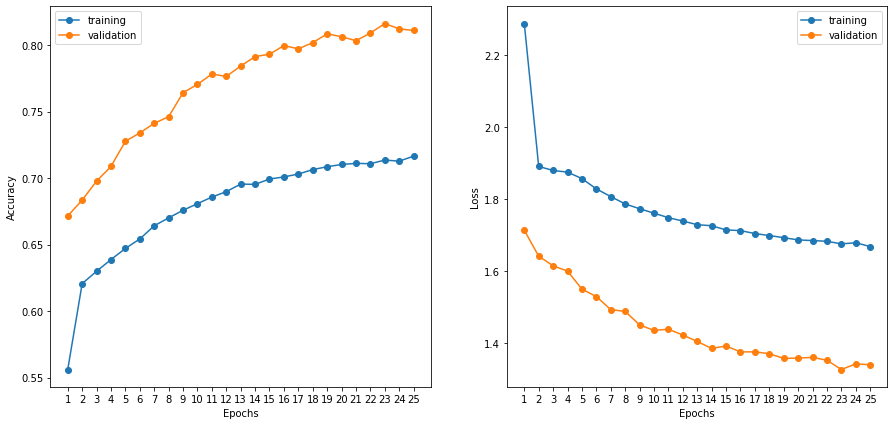

In [102]:
# plotting epoch vs accuracy & loss
epochs = range(1, 26)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["sparse_categorical_accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_sparse_categorical_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

Not much inference can be drawn from the above graphs. However, gap between training and validation keeps on increaseing with the increase in number of epochs. Same is in case with the loss.

Since this is our best performing model in terms of accuracy, let's see the recall and precision.

In [104]:
y_pred = np.argmax(model.predict(test_vec2), axis=-1)

1308/1308 [==============================] - 5s 4ms/step


In [105]:
# Precision 
from sklearn.metrics import precision_score

# precision_score(true labels, predicted labels)
precision_score(y_test, y_pred, average='macro')

0.5675968131620097

In [106]:
# Recall
from sklearn.metrics import recall_score

# recall_score(true labels, predicted labels)
recall_score(y_test, y_pred, average='macro')

0.5435421819608279

In [107]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

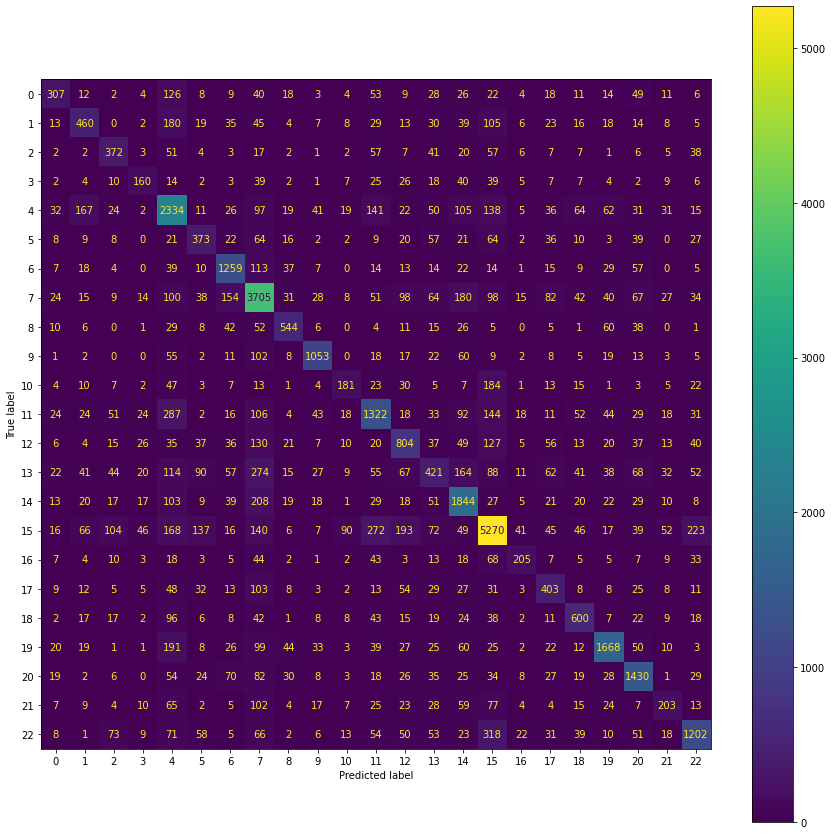

In [108]:
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax)

It's very hard to draw inferences from the above confusion matrix


Let draw a report.

In [96]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.32      0.41       784
           1       0.56      0.39      0.46      1079
           2       0.40      0.62      0.48       711
           3       0.44      0.31      0.36       432
           4       0.50      0.66      0.57      3472
           5       0.47      0.39      0.43       813
           6       0.66      0.74      0.70      1687
           7       0.62      0.74      0.68      4924
           8       0.54      0.70      0.61       864
           9       0.74      0.76      0.75      1415
          10       0.52      0.28      0.37       588
          11       0.62      0.48      0.54      2411
          12       0.55      0.46      0.50      1548
          13       0.35      0.14      0.20      1812
          14       0.53      0.77      0.63      2548
          15       0.70      0.79      0.74      7115
          16       0.62      0.32      0.42       515
          17       0.59    

0 'ARTS & CULTURE'

1'COMEDY'

2'CRIME'

3 'EDUCATION' 

4 'ENTERTAINMENT'

5 'ENVIRONMENT' 

6 'FOOD & DRINK' 

7 'HEALTHY LIVING'

8 'HOME & LIVING'


9 'MARRIAGE & DIVORCE' 

10'MEDIA'

11 'MINORITIES' 

12'MONEY & BUSINESS' 

13 'OTHER NEWS'


14 'PARENTING'

15 'POLITICS'

16 'RELIGION' 


17'SCIENCE & TECH' 

18 'SPORTS'

19 'STYLE & BEAUTY'

20 'TRAVEL'

21 'WOMEN'

22 'WORLD NEWS'

1. __Marriage & divorce__ have the highest precision. (74%)
2. __Politics__ has the highest recall (79%)
3. __Women__ class has the lowest recall (16%)

---

---

### Applying GridSearch to find the optimal type of hyperparameter

A lot of power and time get's wasted trying different number of layers, nodes, reguralization, number of epochs, batch size, loss.


All these things can be done in one step by grid search. However running a full cycle will definately take a lot of time



I tried using it but was not success

In [48]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import bayesian-optimization as

ModuleNotFoundError: ignored

In [44]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [45]:
# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=3, fit_params={'callbacks':[es]}).mean()
    return score

In [52]:
# Set paramaters
params_nn ={
    'neurons': (1024, 512, 256, 128),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 400),
    'epochs': (25, 50, 100)
}
# Run Bayesian Optimization
nn_bo = model(nn_cl_bo, params_nn)
nn_bo.maximize(init_points=25, n_iter=4)

TypeError: ignored

---

Below is the summary of the performace of the models

| Models | Accuracy | Precision | Recall
| --- | --- | --- | --- |
| Basic NN model | 53.24% | --- | --- |
| NN with regularization | 51.81% | --- | --- |
| NN with droput layers and l2 | 58.47% | --- | --- |
| NN with dropout + l2 + batchnormalisation | 57.64% |  --- | --- |
| NN with dimensionality reduction | 57.77% |  --- | --- |
| NN with headline and short description | 60% |  56% | 54% |

__Summary:__

1. We see that adding more epochs, layers results in overfitting in general
2. Adding short description to the scene improves the accuracy of the overall model.
3. Feature engineering can be done by adding polarity and subjectivity into the independent dataset. That will for sure increase the accuracy of the model.
4. NN is the best performing model compared to XGBoost and Random Forest.

---

### Thank You!!